In [1]:
from brian2 import *
from brian2modelfitting import *

INFO       Cache size for target "cython": 1029 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/alteska/.cython/brian_extensions" directory. [brian2]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyte

## HH

In [2]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

dt = 0.01*ms

In [3]:
# Generate a step-current input and an "experimental" voltage trace
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

defaultclock.dt = dt

In [4]:
tau = 0.1*ms

In [5]:
# The model
eqsHH = Equations('''
dnoise/dt = -noise/tau + tau**-0.5*xi : 1
I = noise * 5*nA: amp

dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [6]:
G = NeuronGroup(1, eqsHH, 
                threshold='v > -40*mV',
                refractory='v > -40*mV',
               )
G.v = El

G.set_states(params_correct, units=False)
spike_mon = SpikeMonitor(G)
mon = StateMonitor(G, ['v', 'I'], record=0)

run(2000*ms)


INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.13s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


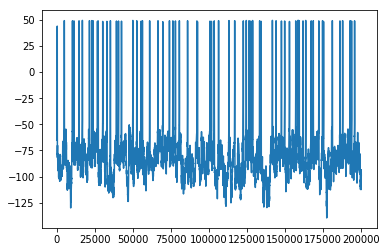

In [7]:
voltage = mon.v[0]/mV
plot(voltage);

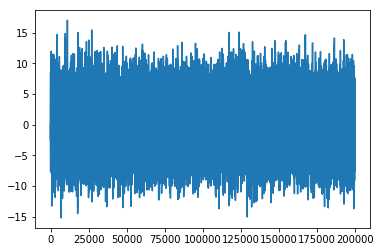

In [8]:
inp_cur = mon.I[0]/nA
plot(inp_cur);

In [9]:
out_spikes = [spike_mon.spike_trains()[0]/ms]
out_spikes

[array([1.88000e+00, 4.84100e+01, 1.01950e+02, 1.12030e+02, 1.45200e+02,
        1.67130e+02, 2.13610e+02, 2.29130e+02, 2.37270e+02, 2.66210e+02,
        2.71190e+02, 3.00760e+02, 3.28420e+02, 3.51250e+02, 3.90940e+02,
        4.04390e+02, 4.24130e+02, 4.98560e+02, 5.24550e+02, 5.52490e+02,
        5.61650e+02, 6.09140e+02, 6.64060e+02, 6.95310e+02, 7.39240e+02,
        7.61810e+02, 7.78430e+02, 8.04440e+02, 8.58330e+02, 9.19690e+02,
        9.23350e+02, 1.00566e+03, 1.01507e+03, 1.03366e+03, 1.06205e+03,
        1.13046e+03, 1.16790e+03, 1.22462e+03, 1.24413e+03, 1.26239e+03,
        1.27310e+03, 1.28573e+03, 1.33188e+03, 1.34166e+03, 1.41574e+03,
        1.43997e+03, 1.47511e+03, 1.49630e+03, 1.52786e+03, 1.56901e+03,
        1.58487e+03, 1.59223e+03, 1.61684e+03, 1.63461e+03, 1.67084e+03,
        1.68440e+03, 1.72057e+03, 1.74537e+03, 1.75187e+03, 1.80967e+03,
        1.85981e+03, 1.87723e+03, 1.92670e+03, 1.93599e+03, 1.95579e+03])]

## IF

In [45]:
I = TimedArray(inp_cur*nA, dt=dt)

In [100]:
R = 76*Mohm
tau = 12.44*ms
taut = 97.64*ms
a = 0.21
alpha = 7.2*mV

model = '''
        dV/dt = (R*I(t)- V)/tau :volt
        dVt/dt = (a*V - Vt) / taut :volt
        '''

threshold = 'V > Vt'
reset = '''
V = 0*mV
Vt = Vt + alpha
'''

In [101]:
start_scope()
neuron = NeuronGroup(1, model=model,
                     threshold=threshold,
                     reset=reset,
                     refractory=1.4*ms,
                     method='exponential_euler')
trace = StateMonitor(neuron, 'V', record=0)
spike_mon = SpikeMonitor(neuron)

In [131]:
run(2000*ms)

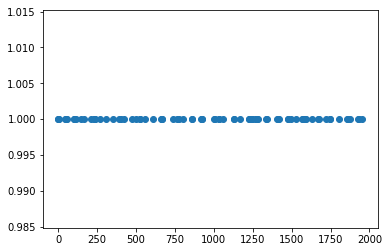

In [132]:
dd = spike_mon.spike_trains()[0]/ms
scatter(dd, np.ones_like(dd));

In [122]:
dd

array([0.04, 1.44, 3.83])

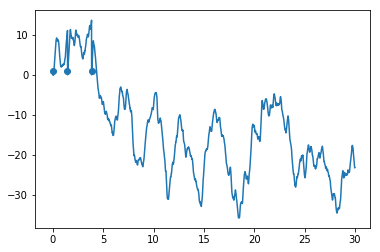

In [130]:
plot(np.arange(0, len(trace.V.transpose()/mV)*0.01, 0.01), trace.V.transpose()/mV);
scatter(dd, np.ones_like(dd));